In [1]:
using Colors
using CSV
using DataFrames
using Graphs
using Plots
using Random: MersenneTwister
using StatsBase: mean, std, countmap
using Statistics

include("../src/ColorScheme.jl")
using .ColorScheme: DARK_RED, LIGHT_RED, GRAY, LIGHT_BLUE, DARK_BLUE, COLOR_GRAD

include("../src/Network.jl")
using .Network: create_weighted_cycle_graph, create_cycle_graph, desc, plot_degree_distribution, mat_nv, mat_ne, mat_degree, mat_update_weight!, plot_graph, average_distance

include("../src/Simulation.jl")
using .Simulation: Param, Model, run!, Strategy, C, D

println("Julia $(VERSION)")
println("Thread count: $(Threads.nthreads())")

Julia 1.10.2
Thread count: 12


# Fig. 2

## 凡例

In [4]:
using Plots
using Printf  # sprintfを使用するためにインポート

# デフォルトのカラースキームを取得
colors = palette(:default)

# 16進数形式に変換する関数
function rgb_to_hex(color::RGB{Float64})
    r = round(Int, red(color) * 255)
    g = round(Int, green(color) * 255)
    b = round(Int, blue(color) * 255)
    return string("#", @sprintf("%02x", r), @sprintf("%02x", g), @sprintf("%02x", b))
end

# カラーコードを出力
for color in colors
    println(rgb_to_hex(color))
end

#009afa
#e36f47
#3ea44e
#c371d2
#ac8e18
#00aaae
#ed5e93
#c68225
#00a98d
#8e971e
#00a9cc
#9b7fe9
#618df6
#f06073
#dd65b6
#6c9f33


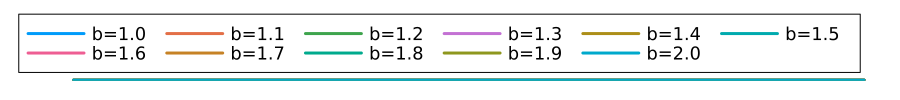

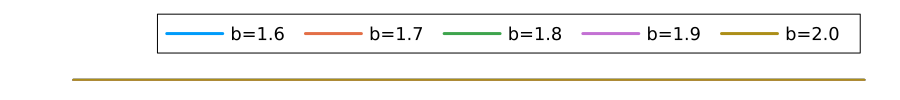

In [5]:
# カラースキームを指定してプロット
p = plot(legend_columns=6, legendfontsize=12, size=(900, 100), framestyle=:none)
bs = 1.0:0.1:2.0
for b in bs
    plot!([1, 1], label="b=$(b)  ", linewidth=2)
end
display(p)

p = plot(legend_columns=5, legendfontsize=12, size=(900, 100), framestyle=:none)
bs = 1.6:0.1:2.0
for b in bs
    plot!([1, 1], label="b=$(b)  ", linewidth=2)
end
display(p)

In [6]:
FILE_NAMES = [
    "../output/CircleModel_20240826_144719.csv",  # σR ∈ 0:49, 10 trials
    "../output/CircleModel_20240826_182404.csv",  # σR ∈ 0:49, 10 trials
    "../output/CircleModel_20240826_200917.csv",  # β ∈ 0.0:0.1:0.9, sigmaθ ∈ {0.01, 0.1, 0.2, 0.3}, 10 trials
    "../output/CircleModel_20240828_113854.csv",  # β ∈ 0.0:0.1:0.9, sigmaθ ∈ {0.01, 0.1, 0.2, 0.3}, 10 trials
    "../output/CircleModel_20240828_191857.csv",  # β ∈ 0.0:0.1:0.9, sigmaθ ∈ {0.01, 0.1, 0.2, 0.3}, 10 trials
    "../output/CircleModel_20240827_170414.csv",  # combination, 10 trials
    "../output/CircleModel_20240827_181750.csv",  # combination, 10 trials
    # "../output/CircleModel_20240827_100534.csv",  # all, 10 trials
    "../output/CircleModel_20240827_215238.csv",  # all, 10 trials
    "../output/CircleModel_20240828_213318.csv",  # all, 10 trials
    "../output/CircleModel_20240829_093929.csv",  # all, 10 trials
    "../output/CircleModel_20240829_154557.csv",  # all, 10 trials
    "../output/CircleModel_20240829_210419.csv",  # all, 10 trials
];

In [7]:
dfs = [DataFrame(CSV.File(n)) for n in FILE_NAMES]
df = vcat(dfs...);

In [8]:
regional_var_df = df[
    df.C_rate₀ .== 0.0 .&&
    df.relationship_increment_factor .== 1.0 .&&
    df.resource_limit_β .== 0.0 .&&
    df.resource_limit_σ .== 0.0, :]

universal_var_df = df[
    df.C_rate₀ .== 0.0 .&&
    df.relationship_increment_factor .== 1.0 .&&
    df.peak_node_variability .== 0 .&&
    df.resource_limit_σ .!= 0.0, :]

b_vec = [1.6, 1.7, 1.8, 1.9, 2.0]
peak_node_variability_vec = [1, 2, 4, 8, 16]
resource_limit_β_vec = [0.1, 0.3, 0.5, 0.7, 0.9]
resource_limit_σ_vec = [0.1, 0.2]

combination_var_df = df[
    df.C_rate₀ .== 0.0 .&&
    df.relationship_increment_factor .== 1.0 .&&
    ([x in b_vec for x in df.b]) .&&
    ([x in peak_node_variability_vec for x in df.peak_node_variability]) .&&
    ([x in resource_limit_β_vec for x in df.resource_limit_β]) .&&
    ([x in resource_limit_σ_vec for x in df.resource_limit_σ]), :]

@show size(regional_var_df)
@show size(universal_var_df)
@show size(combination_var_df)

groupby_combine_sort(df::DataFrame, keys::Vector)::DataFrame = sort(combine(groupby(df, keys), :cooperation_rate => mean => :cooperation_rate))

regional_var_df = groupby_combine_sort(regional_var_df, [:b, :peak_node_variability])
universal_var_df = groupby_combine_sort(universal_var_df, [:b, :resource_limit_β, :resource_limit_σ])
combination_var_df = groupby_combine_sort(combination_var_df, [:b, :peak_node_variability, :resource_limit_β, :resource_limit_σ])

@show size(regional_var_df)
@show size(universal_var_df)
@show size(combination_var_df);

size(regional_var_df) = (3850, 17)
size(universal_var_df) = (3520, 17)
size(combination_var_df) = (1750, 17)
size(regional_var_df) = (550, 3)
size(universal_var_df) = (440, 4)
size(combination_var_df) = (250, 5)


In [9]:
regional_var_df = df[
    df.C_rate₀ .== 0.0 .&&
    df.resource_limit_β .== 0.0 .&&
    df.resource_limit_σ .== 0.0, :]

universal_var_df = df[
    df.C_rate₀ .== 0.0 .&&
    df.peak_node_variability .== 0 .&&
    df.resource_limit_σ .!= 0.0, :]

b_vec = [1.6, 1.7, 1.8, 1.9, 2.0]
peak_node_variability_vec = [1, 2, 4, 8, 16]
resource_limit_β_vec = [0.1, 0.3, 0.5, 0.7, 0.9]
resource_limit_σ_vec = [0.1, 0.2]

combination_var_df = df[
    df.C_rate₀ .== 0.0 .&&
    ([x in b_vec for x in df.b]) .&&
    ([x in peak_node_variability_vec for x in df.peak_node_variability]) .&&
    ([x in resource_limit_β_vec for x in df.resource_limit_β]) .&&
    ([x in resource_limit_σ_vec for x in df.resource_limit_σ]), :]

@show size(regional_var_df)
@show size(universal_var_df)
@show size(combination_var_df)

groupby_combine_sort(df::DataFrame, keys::Vector)::DataFrame = sort(combine(groupby(df, keys), :cooperation_rate => mean => :cooperation_rate))

regional_var_df = groupby_combine_sort(regional_var_df, [:relationship_increment_factor, :b, :peak_node_variability])
universal_var_df = groupby_combine_sort(universal_var_df, [:relationship_increment_factor, :b, :resource_limit_β, :resource_limit_σ])
combination_var_df = groupby_combine_sort(combination_var_df, [:relationship_increment_factor, :b, :peak_node_variability, :resource_limit_β, :resource_limit_σ])

@show size(regional_var_df)
@show size(universal_var_df)
@show size(combination_var_df);

size(regional_var_df) = (11550, 17)
size(universal_var_df) = (10560, 17)
size(combination_var_df) = (5250, 17)
size(regional_var_df) = (1650, 4)
size(universal_var_df) = (1320, 5)
size(combination_var_df) = (750, 6)


In [10]:
default(tickfont=font(10))

function plot_fig_regional(df::DataFrame)::Plots.Plot
    df.peak_node_variability = Float64.(df.peak_node_variability)
    replace!(df.peak_node_variability, 0 => 0.5)
    fRI = df.relationship_increment_factor[1]

    xticks = sort(unique(df.peak_node_variability))
    xticks_label = [x in [1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 49.0] ? "$(Int(x))" : "" for x in xticks]
    xticks_label[1] = "0"

    p = plot(
        xticks=(xticks, xticks_label),
        xscale=:log2,
        xlim=(0.5, 49),
        yticks=0:0.1:1,
        ylim=(0, 1),
        xlabel="\\sigma_R",
        ylabel="Cooperation Rate",
        title="\\sigma f_{RI} = $(fRI) \\sigma",
    )

    for _df in groupby(df, [:b])
        plot!(_df.peak_node_variability, _df.cooperation_rate, label=false, linewidth=1.5)
    end

    savefig("img/fig2_regional_$(fRI).png")

    return p
end

function plot_fig_universal(df::DataFrame)::Vector{Plots.Plot}
    σ_vec = sort(unique(df.resource_limit_σ))
    β_vec = sort(unique(df.resource_limit_β))
    p_vec = []
    fRI = df.relationship_increment_factor[1]

    for σ in σ_vec
        p = plot(
            xticks=β_vec,
            xlim=(minimum(β_vec), maximum(β_vec)),
            yticks=0:0.1:1.0,
            ylim=(0, 1.0),
            xlabel="\\beta",
            ylabel="Cooperation Rate",
            title="\\sigma_{\\theta} = $(σ), f_{RI} = $(fRI)",
        )
    
        for _df in groupby(df[df.resource_limit_σ .== σ, :], [:b])
            plot!(_df.resource_limit_β, _df.cooperation_rate, label=false, linewidth=1.5)
        end

        push!(p_vec, p)
        savefig("img/fig2_universal_$(fRI)_$(σ).png")
    end

    return p_vec
end;

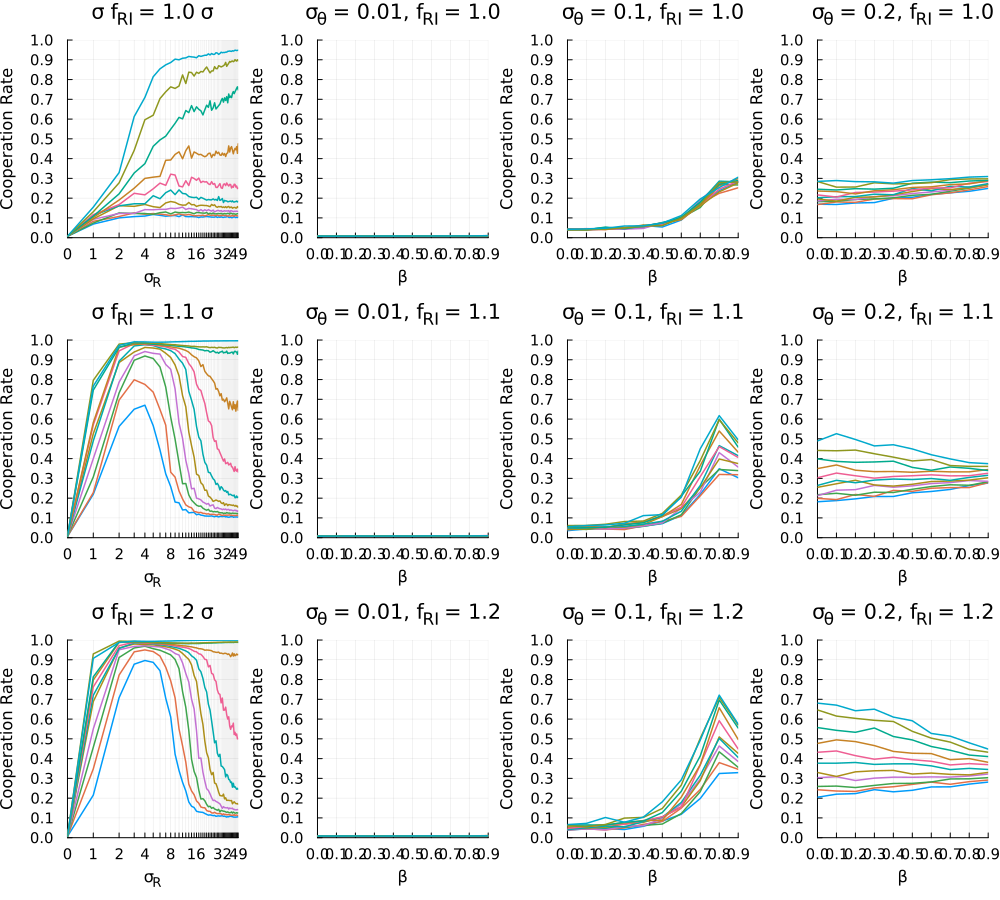

In [11]:
regional_plot_10 = plot_fig_regional(regional_var_df[regional_var_df.relationship_increment_factor .== 1.0, :])
regional_plot_11 = plot_fig_regional(regional_var_df[regional_var_df.relationship_increment_factor .== 1.1, :])
regional_plot_12 = plot_fig_regional(regional_var_df[regional_var_df.relationship_increment_factor .== 1.2, :])
universal_plot_10_vec = plot_fig_universal(universal_var_df[universal_var_df.relationship_increment_factor .== 1.0, :])
universal_plot_11_vec = plot_fig_universal(universal_var_df[universal_var_df.relationship_increment_factor .== 1.1, :])
universal_plot_12_vec = plot_fig_universal(universal_var_df[universal_var_df.relationship_increment_factor .== 1.2, :])

plot(
    regional_plot_10,
    universal_plot_10_vec[1],
    universal_plot_10_vec[2],
    universal_plot_10_vec[3],
    regional_plot_11,
    universal_plot_11_vec[1],
    universal_plot_11_vec[2],
    universal_plot_11_vec[3],
    regional_plot_12,
    universal_plot_12_vec[1],
    universal_plot_12_vec[2],
    universal_plot_12_vec[3],
    layout=(3, 4), size=(1000, 900)
) |> display

# Fig. 5

In [16]:
function plot_fig_combination(df::DataFrame)::Plots.Plot
    b_vec = sort(unique(combination_var_df.b))
    σR_vec = sort(unique(combination_var_df.peak_node_variability))
    σθ_vec = sort(unique(combination_var_df.resource_limit_σ))
    β_vec = sort(unique(combination_var_df.resource_limit_β))
    p_vec = []

    for σθ in σθ_vec
        @show σθ
        for β in β_vec
            _df = combination_var_df[combination_var_df.resource_limit_σ .== σθ .&& combination_var_df.resource_limit_β .== β, :]
            p = plot(
                xticks=(1:length(σR_vec), σR_vec),
                xlim=(1, length(σR_vec)),
                # xscale=:log2,
                yticks=0:0.1:1.0,
                ylim=(0, 1.0),
                xlabel="",
                ylabel="",
                title="",
            )
            for __df in groupby(_df, [:b])
                plot!(__df.cooperation_rate, label=false)
            end
            push!(p_vec, p)
        end

        for σR in σR_vec
            _df = combination_var_df[combination_var_df.resource_limit_σ .== σθ .&& combination_var_df.peak_node_variability .== σR, :]
            p = plot(
                xticks=(1:length(β_vec), β_vec),
                xlim=(1, length(β_vec)),
                yticks=0:0.1:1.0,
                ylim=(0, 1.0),
                xlabel="",
                ylabel="",
                title="",
            )
            for __df in groupby(_df, [:b])
                plot!(__df.cooperation_rate, label=false)
            end
            push!(p_vec, p)
        end
    end

    return plot(p_vec..., layout=(4, 5), size=(900, 800), hspace=0.0)
end;

σθ = 0.1
σθ = 0.2


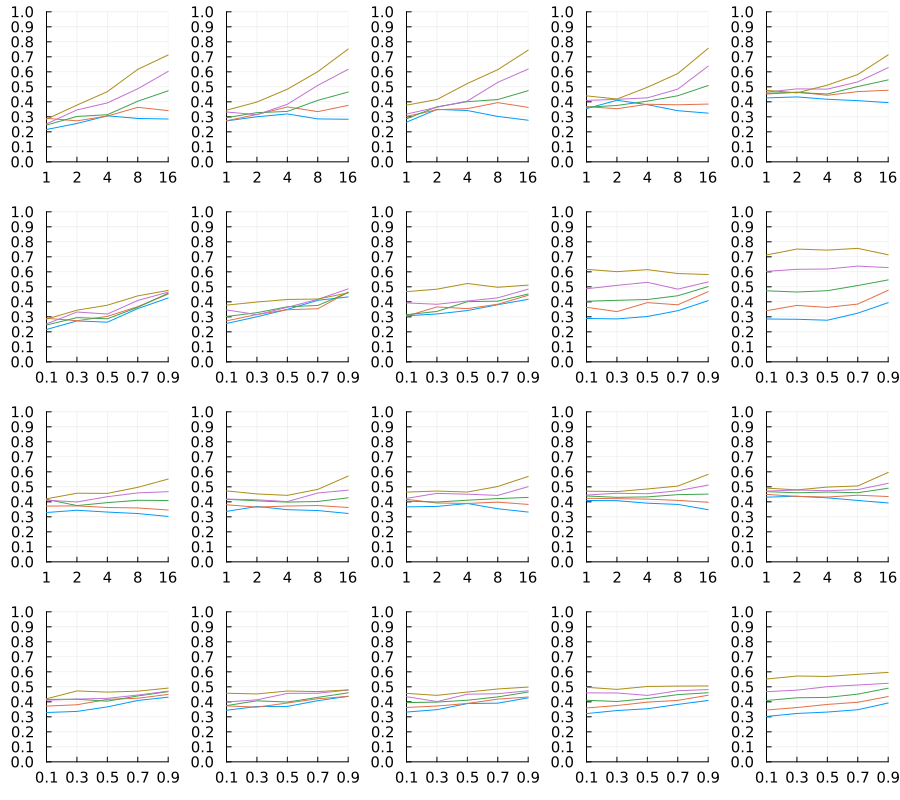

In [17]:
p = plot_fig_combination(combination_var_df)
p |> display
# savefig("fig_combination.png");